In [4]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import os,io
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms
import time, copy

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = '/home/ec2-user/SageMaker/data/statefarm/imgs/'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'test']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
torch.cuda.current_device()

0

In [7]:
train_data = datasets.ImageFolder('/home/ec2-user/SageMaker/data/statefarm/imgs/train/', data_transforms['train'])

In [8]:
from torch.utils.data.dataset import random_split

#image_datasets['train’], image_datasets[‘val’] = random_split(image_datasets[‘train’],[train_dataset_len//2, train_dataset_len-dataset_len//2] )
length = len(train_data)
train_len = int(length*0.8)
train, val = random_split(train_data, [train_len, length-train_len])

In [9]:
trainloaders = torch.utils.data.DataLoader(train, batch_size=4,shuffle=True, num_workers=4)
valloaders = torch.utils.data.DataLoader(val, batch_size=4,shuffle=True, num_workers=4)

dataset_sizes = {'train': len(train), 'val': len(val)}
class_names = train.dataset.classes


In [10]:
dataloaders = {'train': trainloaders, 'val': valloaders}

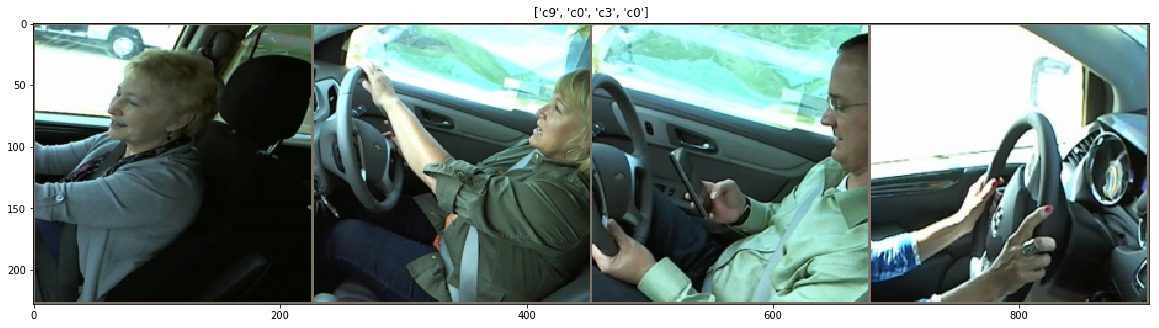

In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
m = models.resnet34(pretrained=True)

In [14]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
model_ft

NameError: name 'model_ft' is not defined

In [20]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [162]:
model_resnet101 = models.resnet101(pretrained=True)
num_ftrs = model_resnet101.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_resnet101.fc = nn.Linear(num_ftrs, len(class_names))

model_resnet101 = model_resnet101.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_resnet101.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 157MB/s]  


In [ ]:
%%capture output

model_ft = train_model(model_resnet101, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

In [171]:
output.show()

Epoch 0/14
----------
train Loss: 0.3130 Acc: 0.8939
val Loss: 0.2426 Acc: 0.9195

Epoch 1/14
----------
train Loss: 0.2925 Acc: 0.9021
val Loss: 0.2458 Acc: 0.9213

Epoch 2/14
----------
train Loss: 0.2073 Acc: 0.9291
val Loss: 0.1940 Acc: 0.9342

Epoch 3/14
----------
train Loss: 0.1895 Acc: 0.9343
val Loss: 0.1632 Acc: 0.9476

Epoch 4/14
----------
train Loss: 0.1726 Acc: 0.9406
val Loss: 0.1572 Acc: 0.9460

Epoch 5/14
----------
train Loss: 0.1675 Acc: 0.9422
val Loss: 0.1706 Acc: 0.9440

Epoch 6/14
----------
train Loss: 0.1615 Acc: 0.9439
val Loss: 0.1487 Acc: 0.9494

Epoch 7/14
----------
train Loss: 0.1544 Acc: 0.9477
val Loss: 0.1506 Acc: 0.9465

Epoch 8/14
----------
train Loss: 0.1584 Acc: 0.9454
val Loss: 0.1679 Acc: 0.9436

Epoch 9/14
----------
train Loss: 0.1510 Acc: 0.9463
val Loss: 0.1543 Acc: 0.9467

Epoch 10/14
----------
train Loss: 0.1495 Acc: 0.9480
val Loss: 0.1415 Acc: 0.9525

Epoch 11/14
----------
train Loss: 0.1422 Acc: 0.9518
val Loss: 0.1497 Acc: 0.9456

Ep

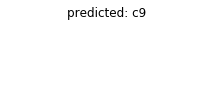

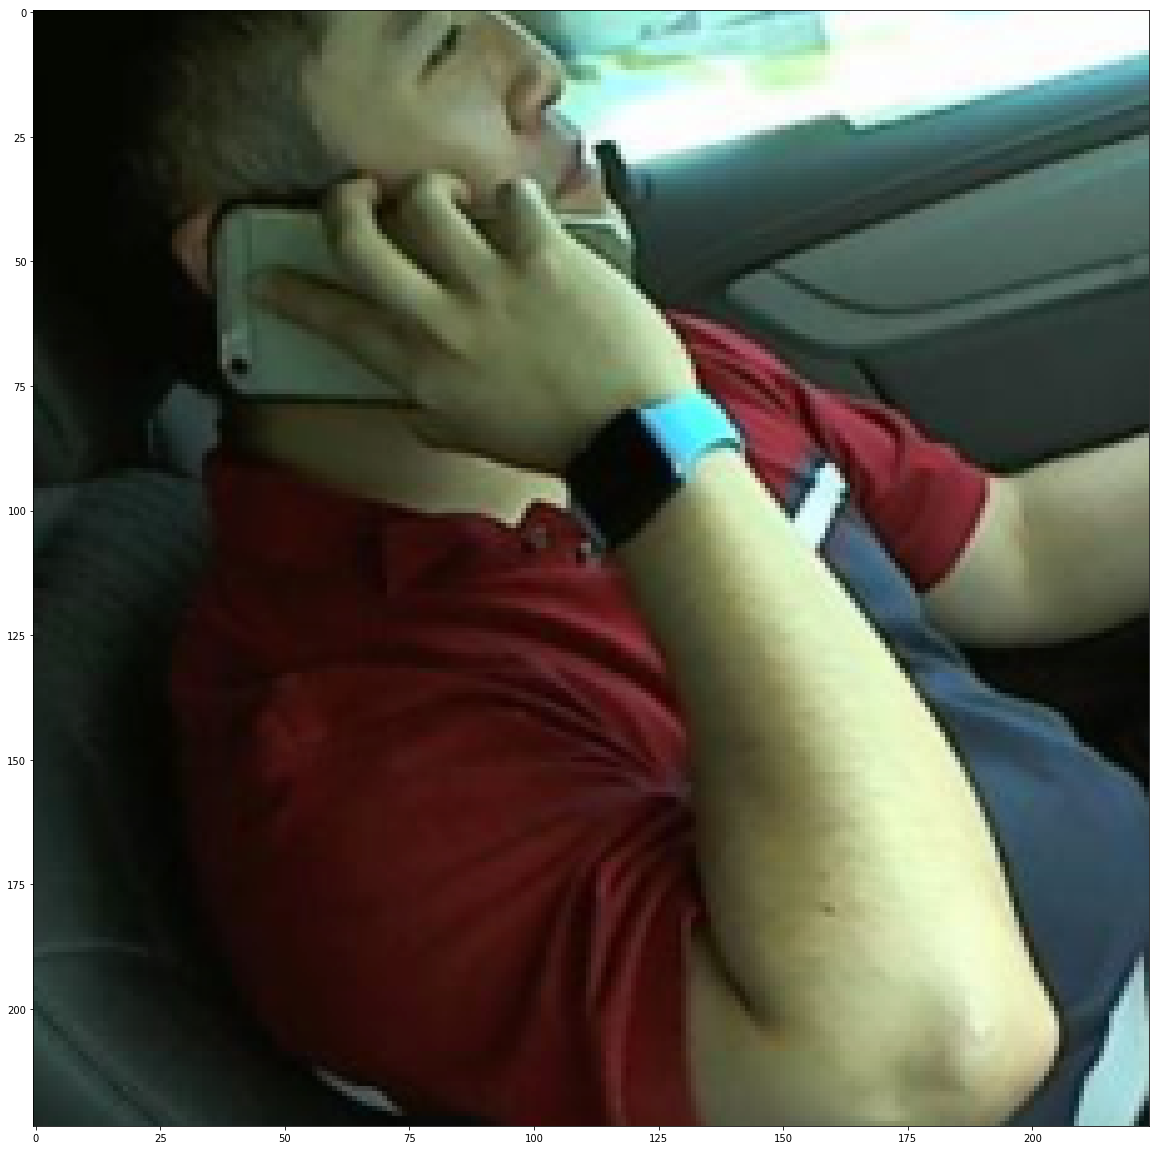

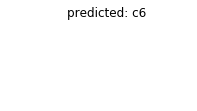

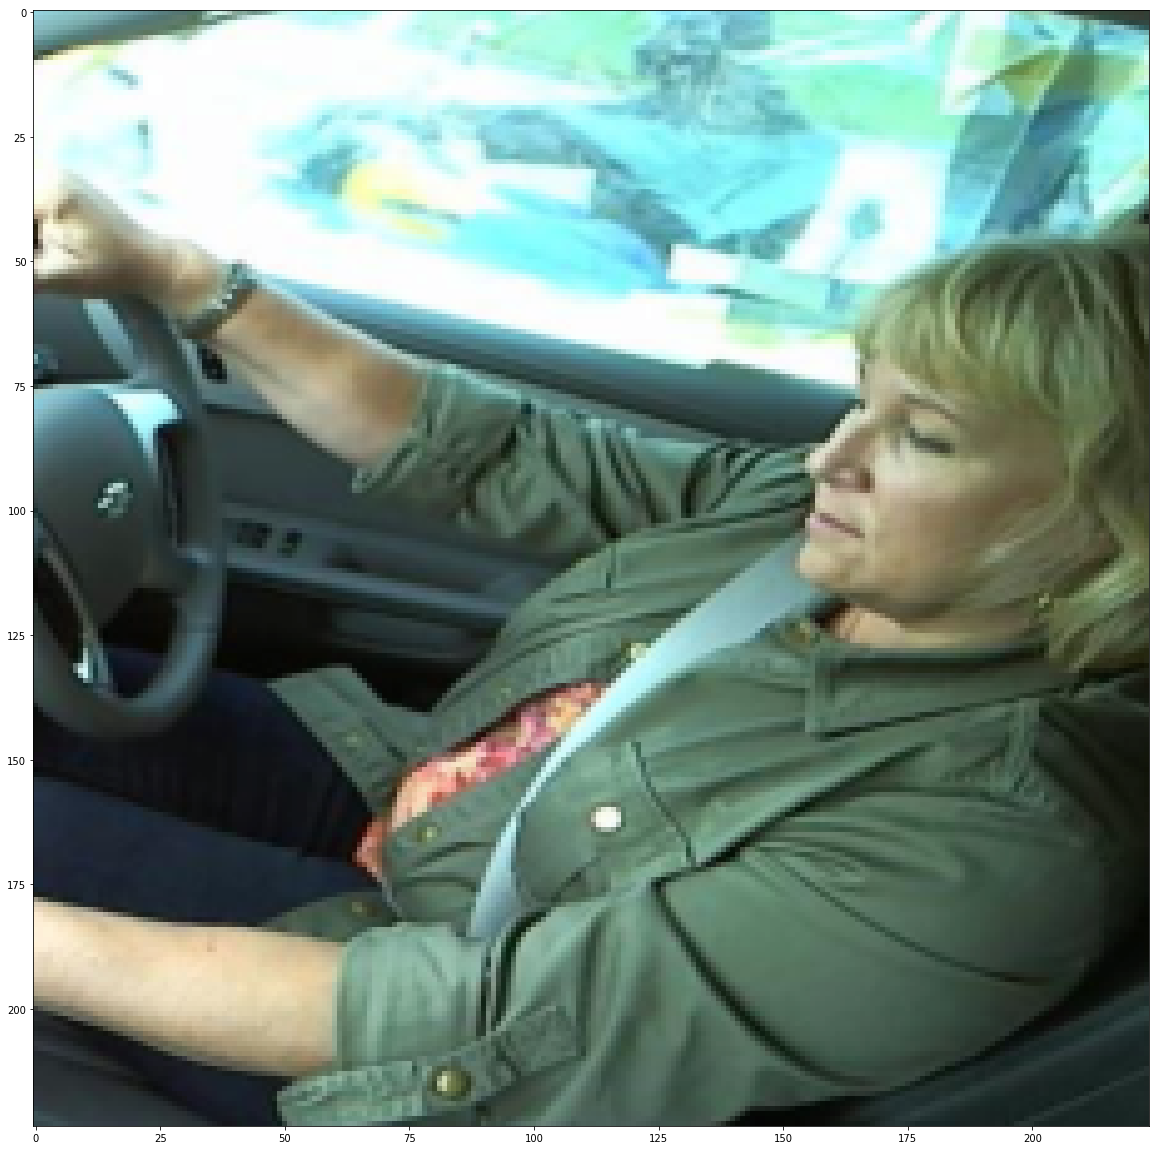

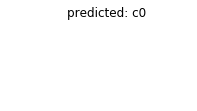

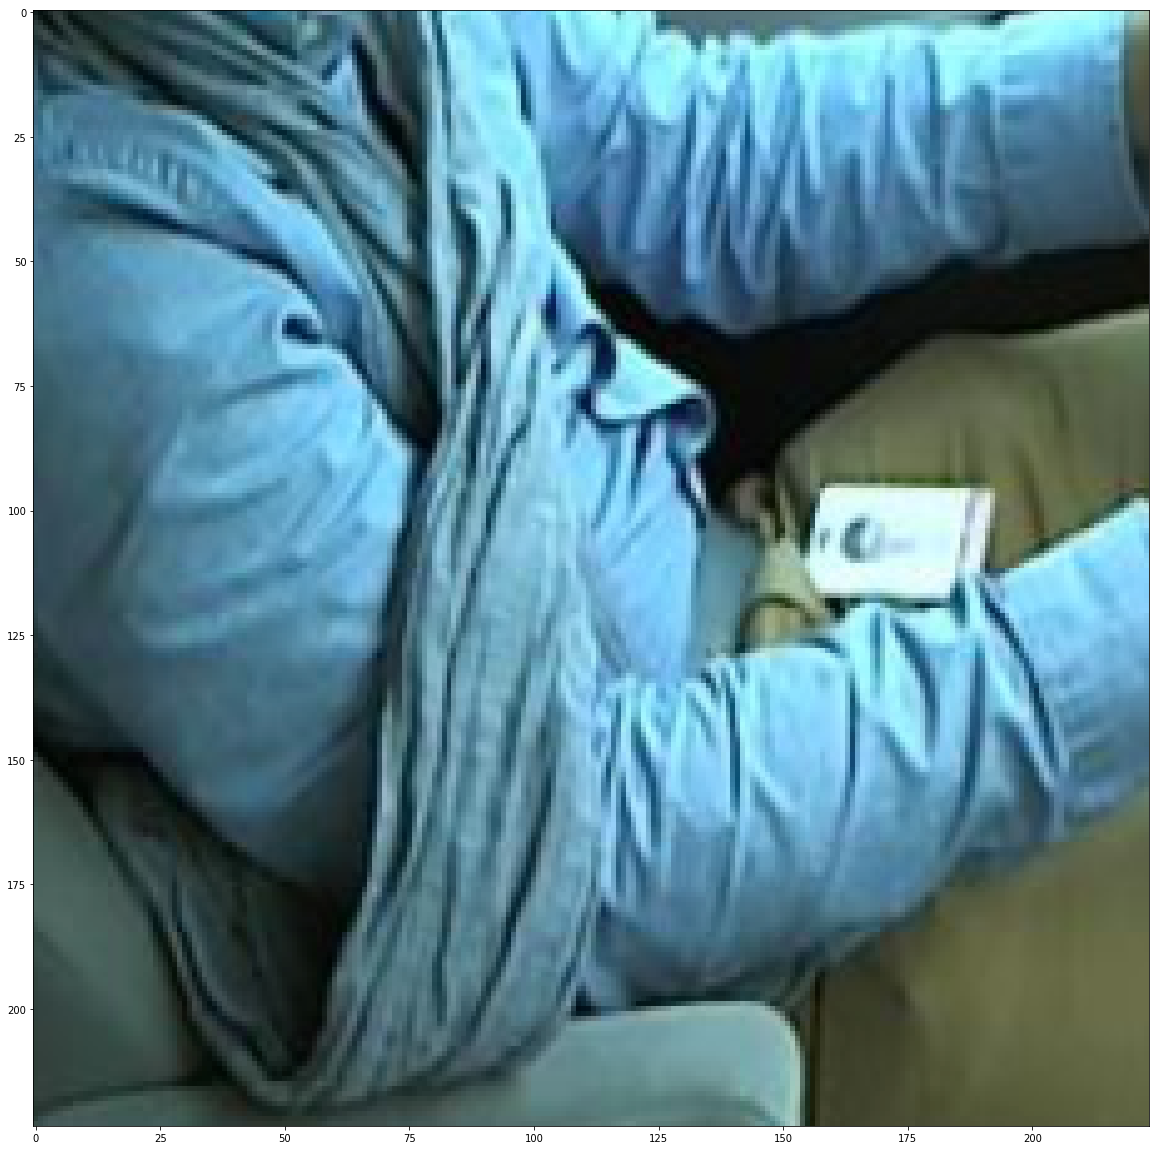

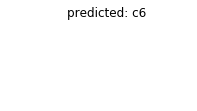

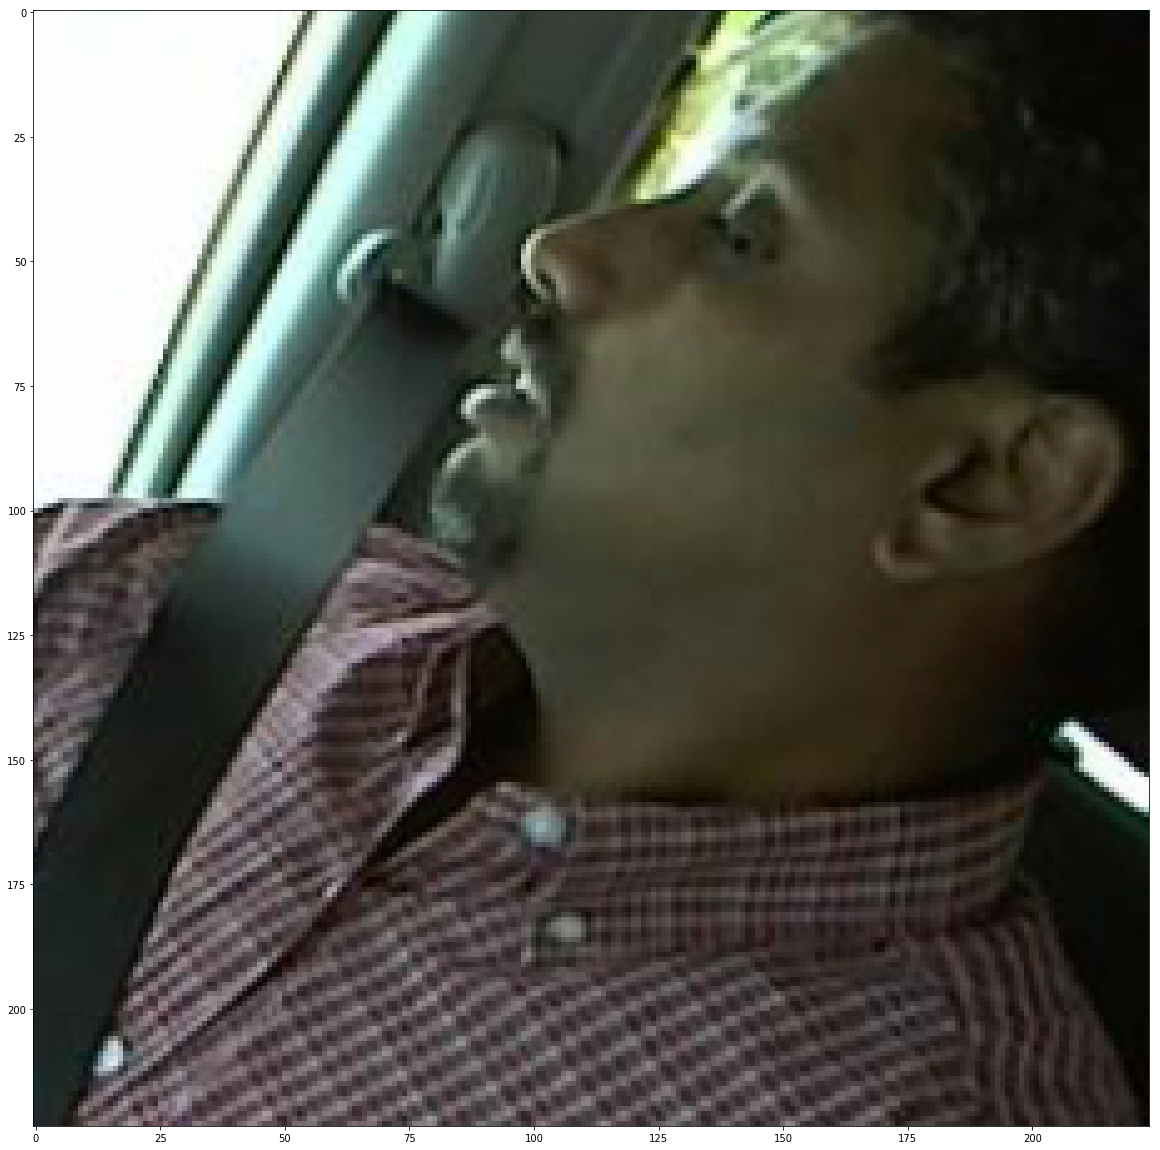

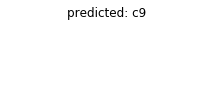

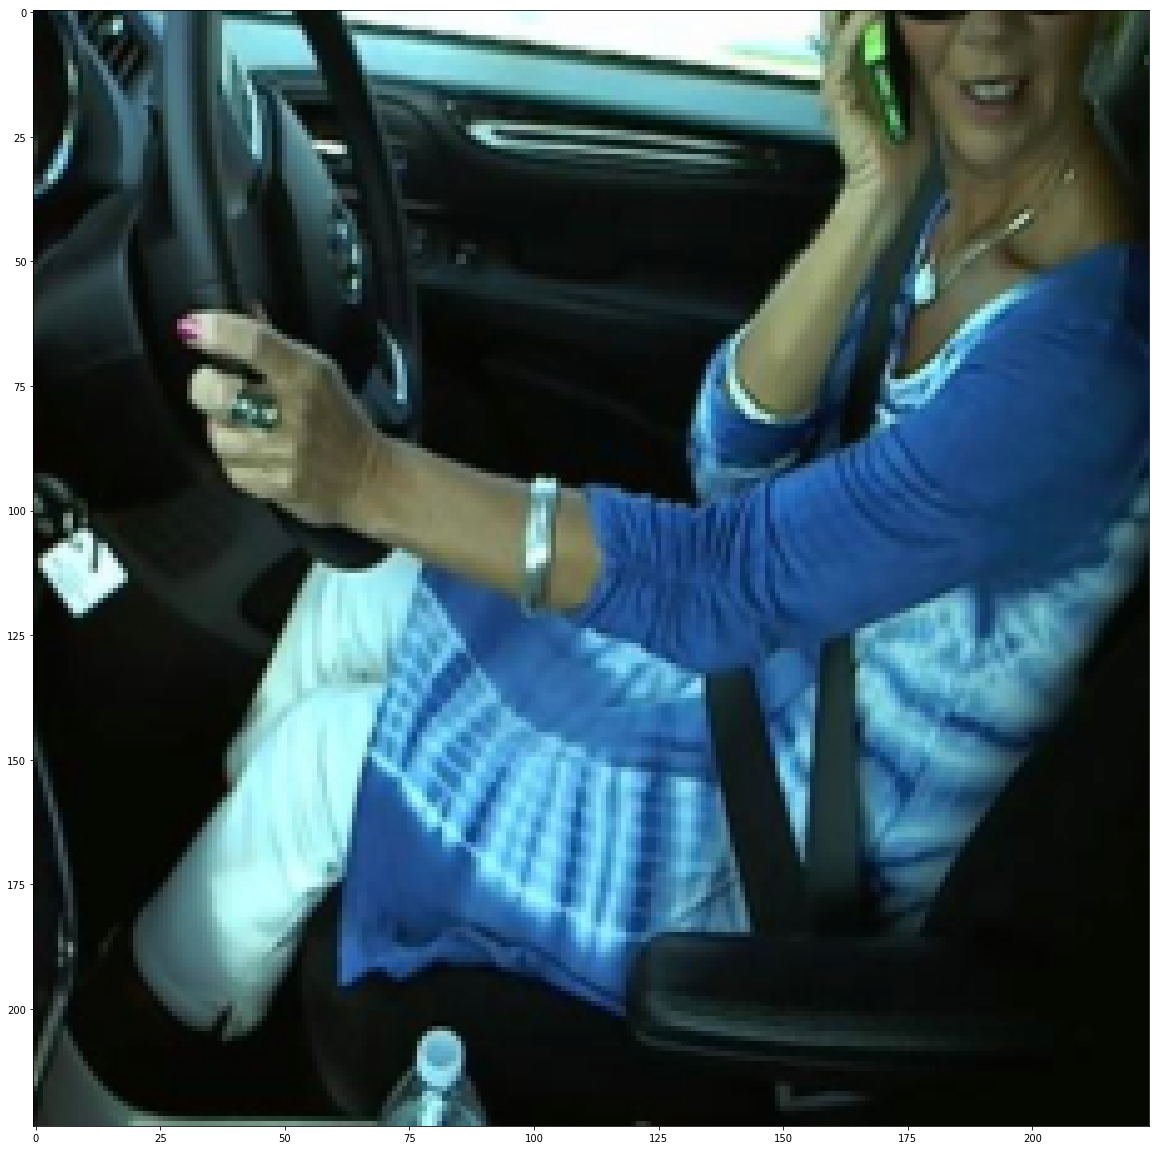

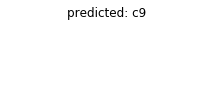

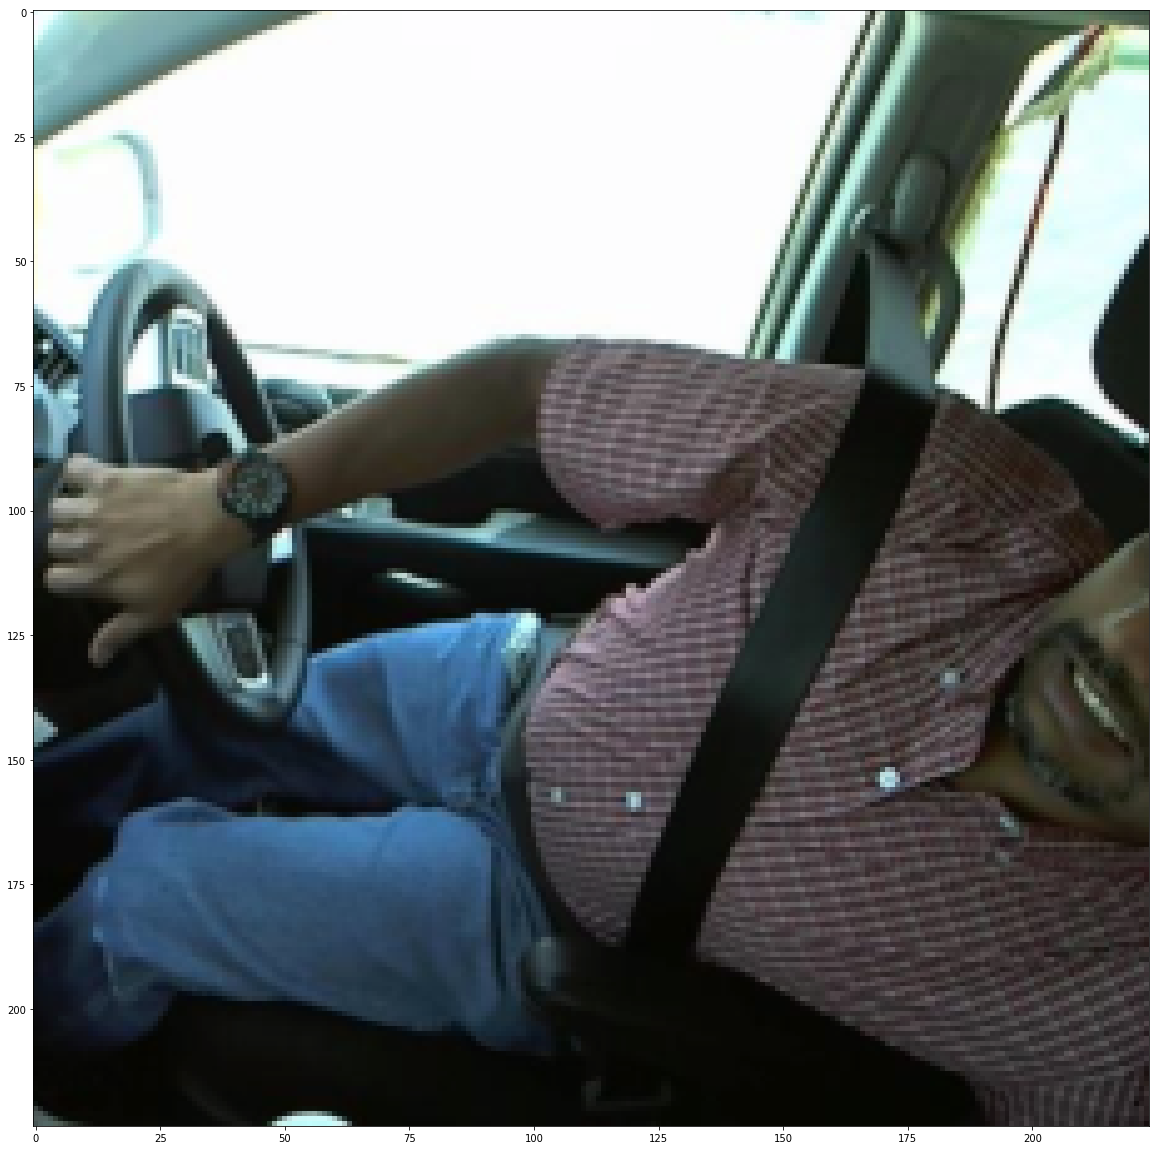

In [166]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        

visualize_model(model_resnet101)

In [165]:
torch.save(model_ft.state_dict(), '/home/ec2-user/SageMaker/resnet50.tar')

Model training for resnet 50: 

Epoch 0/24
----------
train Loss: 0.1775 Acc: 0.9387
val Loss: 0.1579 Acc: 0.9474

Epoch 1/24
----------
train Loss: 0.1709 Acc: 0.9426
val Loss: 0.1609 Acc: 0.9429

Epoch 2/24
----------
train Loss: 0.1790 Acc: 0.9403
val Loss: 0.1483 Acc: 0.9483

Epoch 3/24
----------
train Loss: 0.1738 Acc: 0.9414
val Loss: 0.1534 Acc: 0.9445

Epoch 4/24
----------
train Loss: 0.1918 Acc: 0.9356
val Loss: 0.1539 Acc: 0.9487

Epoch 5/24
----------
train Loss: 0.1905 Acc: 0.9348
val Loss: 0.1620 Acc: 0.9460

Epoch 6/24
----------
train Loss: 0.1711 Acc: 0.9419
val Loss: 0.1631 Acc: 0.9463

Epoch 7/24
----------
train Loss: 0.1812 Acc: 0.9394
val Loss: 0.1531 Acc: 0.9456

Epoch 8/24
----------
train Loss: 0.1799 Acc: 0.9388
val Loss: 0.1522 Acc: 0.9485

Epoch 9/24
----------
train Loss: 0.1701 Acc: 0.9435
val Loss: 0.1668 Acc: 0.9456

Epoch 10/24
----------
train Loss: 0.1716 Acc: 0.9412
val Loss: 0.1800 Acc: 0.9378

Epoch 11/24
----------
train Loss: 0.1890 Acc: 0.9358
val Loss: 0.1676 Acc: 0.9400

Epoch 12/24
----------
train Loss: 0.1778 Acc: 0.9394
val Loss: 0.1517 Acc: 0.9469

Epoch 13/24
----------
train Loss: 0.1770 Acc: 0.9409
val Loss: 0.1573 Acc: 0.9445

Epoch 14/24
----------
train Loss: 0.1801 Acc: 0.9384
val Loss: 0.1467 Acc: 0.9507

Epoch 15/24
----------
train Loss: 0.1708 Acc: 0.9410
val Loss: 0.1567 Acc: 0.9474

Epoch 16/24
----------
train Loss: 0.1727 Acc: 0.9414
val Loss: 0.1601 Acc: 0.9456

Epoch 17/24
----------
train Loss: 0.1802 Acc: 0.9407
val Loss: 0.1429 Acc: 0.9512

Epoch 18/24
----------
train Loss: 0.1766 Acc: 0.9406
val Loss: 0.1766 Acc: 0.9356

Epoch 19/24
----------
train Loss: 0.1741 Acc: 0.9409
val Loss: 0.1579 Acc: 0.9463

Epoch 20/24
----------
train Loss: 0.1787 Acc: 0.9390
val Loss: 0.1713 Acc: 0.9382

Epoch 21/24
----------
train Loss: 0.1750 Acc: 0.9409
val Loss: 0.1422 Acc: 0.9487

Epoch 22/24
----------
train Loss: 0.1786 Acc: 0.9424
val Loss: 0.1538 Acc: 0.9496

Epoch 23/24
----------
train Loss: 0.1751 Acc: 0.9412
val Loss: 0.1726 Acc: 0.9440

Epoch 24/24
----------
train Loss: 0.1753 Acc: 0.9421
val Loss: 0.1632 Acc: 0.9454

Training complete in 202m 47s
Best val Acc: 0.951171

In [169]:
output.show()

Epoch 0/4
----------
train Loss: 0.9375 Acc: 0.6940
val Loss: 0.6247 Acc: 0.7933

Epoch 1/4
----------
train Loss: 0.5408 Acc: 0.8226
val Loss: 0.3949 Acc: 0.8716

Epoch 2/4
----------
train Loss: 0.4410 Acc: 0.8568
val Loss: 0.3271 Acc: 0.8899

Epoch 3/4
----------
train Loss: 0.3735 Acc: 0.8760
val Loss: 0.2917 Acc: 0.9039

Epoch 4/4
----------
train Loss: 0.3320 Acc: 0.8906
val Loss: 0.2688 Acc: 0.9052

Training complete in 97m 38s
Best val Acc: 0.905240


In [76]:
import glob
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.jpg')
        self.transform = transform
        self.current_path = ''

    def __getitem__(self, index):
        self.current_path = self.image_paths[index]
        x = Image.open(self.image_paths[index])
        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.image_paths)
    
test = TestDataset('/home/ec2-user/SageMaker/data/statefarm/imgs/test/', transform=data_transforms['test'])

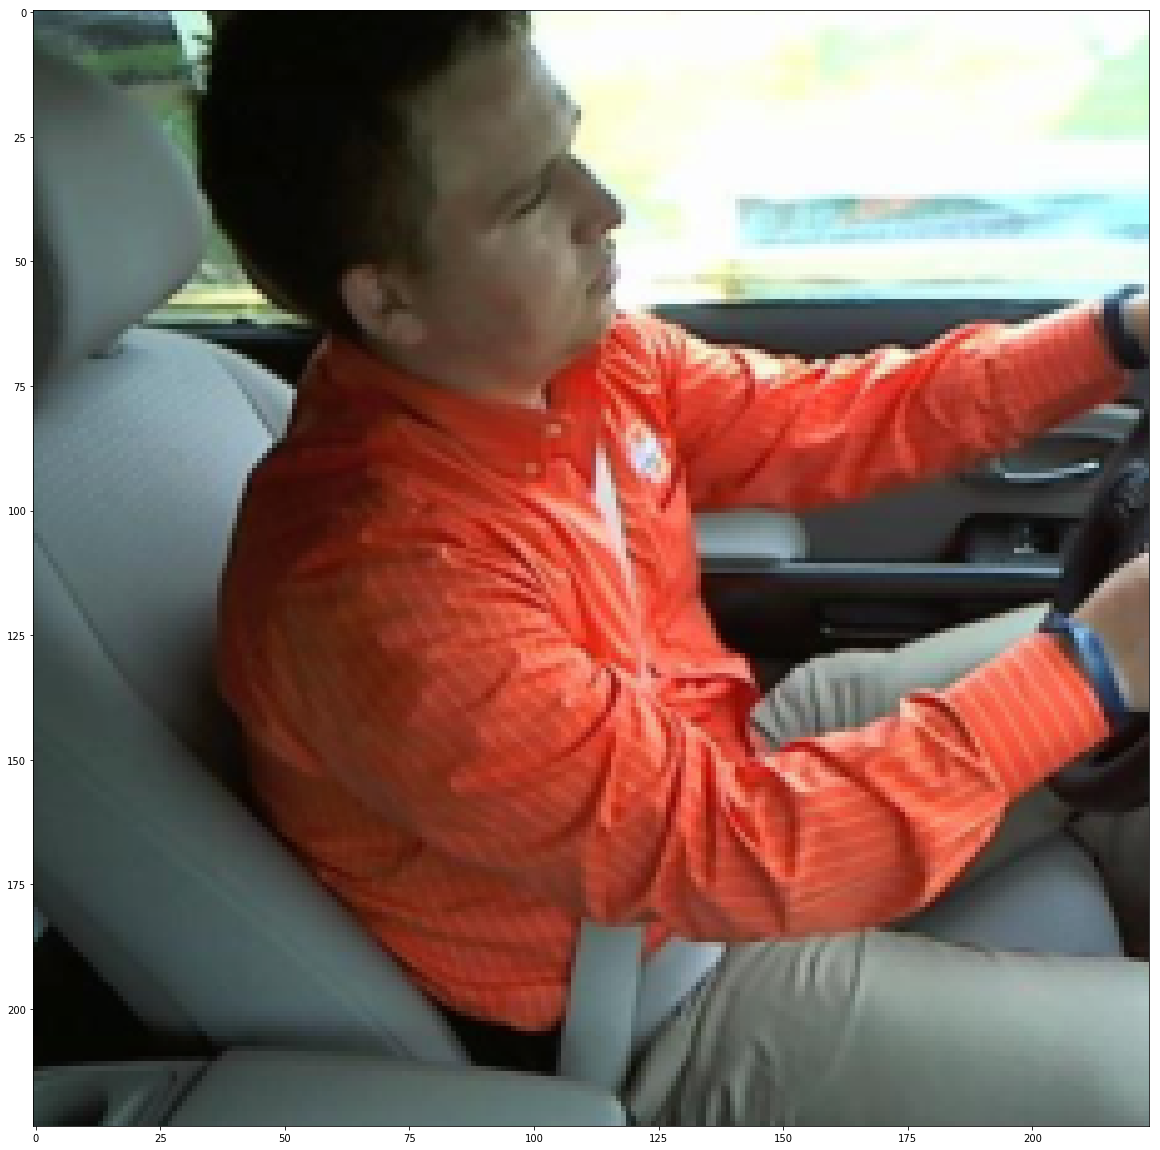

In [45]:
imshow(test[0])

In [89]:
testloaders = torch.utils.data.DataLoader(test, batch_size=4,shuffle=False, num_workers=1)

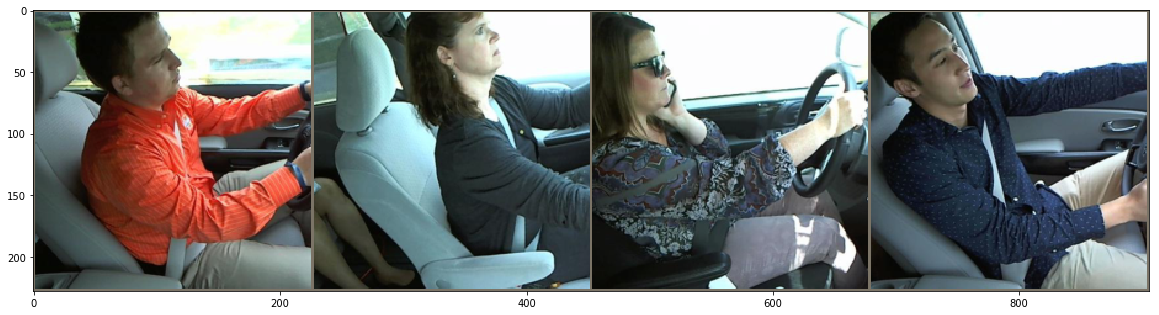

In [90]:
# Get a batch of training data
inputs = next(iter(testloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [179]:
model_densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [180]:
model_densenet = models.densenet161(pretrained=True)
num_ftrs = model_densenet.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_densenet.classifier = nn.Linear(num_ftrs, len(class_names))

model_densenet = model_densenet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_densenet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
%%capture output_densenet

model_densenet = train_model(model_densenet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

In [ ]:
submission2 = []
with torch.no_grad():
    for i, (inputs) in enumerate(testloaders):
        inputs = inputs.to(device)
        outputs = model_densenet(inputs)
        _, preds = torch.max(outputs, 1)
        [submission2.append(x) for x in outputs]


In [ ]:
s = [(s1 + s2 + s3)/3 for s1,s2,s3 in zip(submission, submission1, submission2)]

In [ ]:
# with torch.no_grad():
#     for i, (inputs,labels) in enumerate(valloaders):
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         outputs = model_ft(inputs)
#         _, preds = torch.max(outputs, 1)
#         print(outputs)

In [ ]:
import re
m = nn.Softmax(dim=0)

type(re.findall('/home/ec2-user/SageMaker/data/statefarm/imgs/test/([a-z0-9_]+.jpg)',test.image_paths[0])[0])

In [ ]:
with open('/home/ec2-user/SageMaker/submission_statefarm.csv','w+') as f:
    f.write('img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9\n')
    for path, sub in zip(test.image_paths, s):
        p = re.findall('/home/ec2-user/SageMaker/data/statefarm/imgs/test/([a-z0-9_]+.jpg)', path)[0]
        f.write(p)
        [f.write(',' + str(x)) for x in m(sub).tolist()]
        f.write('\n')
f.close()

In [ ]:
kaggle competitions submit -c state-farm-distracted-driver-detection -f submission.csv -m "Resnet50 + Resnet101 + DenseNet161"

In [160]:
import pandas as pd

df = pd.read_csv('/home/ec2-user/SageMaker/submission_statefarm.csv')

In [161]:
df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_55224.jpg,0.116033,0.000727,1.275300e-03,1.684962e-03,0.000695,0.000119,0.016313,0.000219,0.197171,0.665764
1,img_57208.jpg,0.000008,0.000003,4.904717e-07,6.329832e-09,0.000025,0.997195,0.000016,0.000021,0.002602,0.000130
2,img_62941.jpg,0.000113,0.000324,1.777265e-05,7.838883e-06,0.975937,0.001351,0.000065,0.013146,0.007972,0.001068
3,img_95502.jpg,0.001011,0.000074,1.346262e-06,1.066176e-04,0.000832,0.000413,0.000060,0.000076,0.013840,0.983586
4,img_54671.jpg,0.000044,0.000024,9.963451e-01,2.141088e-05,0.000052,0.000012,0.000574,0.000570,0.000814,0.001543


|Submission and Description| Private Score|Public Score| Private Score Rank|
|--------------------------|--------------|------------|-------------------|
|p3|0.26409|0.27485|154|
|Ensemble ResNet50 + Resnet101|0.28288|0.31784|174|
|Try 1|0.33972|0.39652|228|
